# MD Fakrul Islam, Certified Data Scientist, Machine Learning, Deep Learning   Engineer and Big Data Professional
# Email: fakruldsebd@gmail.com
# Phone: +8801954345775
# https://www.linkedin.com/in/fakrul-islam-bd/
# https://github.com/aifakrul
## Contact for nlp/nlu, image, audio/speech, video processing and contextual ai in real time to solve your complex **Business AI Problem**

# Project Details


```
Identify diseases of below plants using convolutional neural networks (CNN), transfer learning strategy and multilevel classifications. 

Apple- 3 Deadly diseases
Grape- 3 Deadly diseases
Maize- 3 Deadly diseases
Potato- 2 Deadly diseases
Tomato- 9 Deadly diseases


You can collect the Dataset from my Google Drive:
https://drive.google.com/file/d/1odLdFTMf_U-SkCTa0JIWmzVFTmV14paO/view?usp=sharing


Assess the top layer accuracy of:

MobileNetV2
ResNet50V2
ResNet101V2
ResNet152V2
Xception
VGG16
VGG19
InceptionResNetV2
InceptionV3

To learn about the CNN, please visit

https://arxiv.org/
https://en.wikipedia.org/wiki/Convolutional_neural_network
https://www.tensorflow.org/federated

```



# Import Necessery Library

In [1]:
import os, sys, math, time
import numpy as np
from matplotlib import pyplot as plt
if 'google.colab' in sys.modules: 
  %tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE

Tensorflow version 2.2.0


# Mount the google drive drive to fetch datasets

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Split Dataset into Training and Validation

In [3]:
IMAGE_FILE_LOCATION = '/content/drive/My Drive/Plant_Disease_Clinic/Tomato/*/*.JPG'
TF_RECORD_LOCATION = '/content/drive/My Drive/Plant_Disease_Clinic/tomato_tfrecords/*.tfrec'

IMAGE_SIZE = [128, 128]

BATCH_SIZE = 64 # 128 works on GPU too but comes very close to the memory limit of the Colab GPU
EPOCHS=12

VALIDATION_SPLIT = 0.20
CLASSES = [b'Bacterial_Spot', b'Early_Blight', b'Healthy', b'Late_Blight', b'Leaf_Mold', b'Mosaic_Virus' , b'Septoria_Leaf_Spot', b'Target_Spot', b'Two_Spotted_Spider_Mite', b'Yellow_Leaf_Curl_Virus' ] # do not change, maps to the labels in the data (folder names)

NO_OF_CLASSES=len(CLASSES)

total_image_files = len(tf.io.gfile.glob(IMAGE_FILE_LOCATION))

# splitting data files between training and validation
filenames = tf.io.gfile.glob(TF_RECORD_LOCATION)
split = int(len(filenames) * VALIDATION_SPLIT)
training_filenames = filenames[split:]
validation_filenames = filenames[:split]
print("Pattern matches {} data files. Splitting dataset into {} training files and {} validation files".format(len(filenames), len(training_filenames), len(validation_filenames)))
validation_steps = int(total_image_files // len(filenames) * len(validation_filenames)) // BATCH_SIZE
steps_per_epoch = int(total_image_files // len(filenames) * len(training_filenames)) // BATCH_SIZE
print("With a batch size of {}, there will be {} batches per training epoch and {} batch(es) per validation run.".format(BATCH_SIZE, steps_per_epoch, validation_steps))

print(NO_OF_CLASSES)
#print(filenames)
#print(len(filenames))
#print(len(validation_filenames))
#print(len(training_filenames))
#print(validation_steps)
#print(steps_per_epoch)
#print(CLASSES)
#print(validation_filenames)
#print(training_filenames)

Pattern matches 16 data files. Splitting dataset into 13 training files and 3 validation files
With a batch size of 64, there will be 251 batches per training epoch and 58 batch(es) per validation run.
10


# Configure all utilities function

In [4]:
def dataset_to_numpy_util(dataset, N):
  dataset = dataset.batch(N)
  
  for images, labels in dataset:
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    break;

  return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
  correct = (label == correct_label)
  return "{} [{}{}{}]".format(CLASSES[label], str(correct), ', shoud be ' if not correct else '',
                              CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16, color='red' if red else 'black')
    return subplot+1
  
def display_9_images_from_dataset(dataset):
  subplot=331
  plt.figure(figsize=(13,13))
  images, labels = dataset_to_numpy_util(dataset, 9)
  for i, image in enumerate(images):
    title = CLASSES[labels[i]]
    subplot = display_one_flower(image, title, subplot)
    if i >= 8:
      break;
              
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()
  
def display_9_images_with_predictions(images, predictions, labels):
  subplot=331
  plt.figure(figsize=(13,13))
  classes = np.argmax(predictions, axis=-1)
  for i, image in enumerate(images):
    title, correct = title_from_label_and_target(classes[i], labels[i])
    subplot = display_one_flower(image, title, subplot, not correct)
    if i >= 8:
      break;
              
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()
  
def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

#Read images and labels from TFRecords

In [5]:
def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means scalar
    }
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size will be needed for TPU
    class_label = example['class']
    return image, class_label

def load_dataset(filenames):
  # read from TFRecords. For optimal performance, read from multiple
  # TFRecord files at once and set the option experimental_deterministic = False
  # to allow order-altering optimizations.

  option_no_order = tf.data.Options()
  option_no_order.experimental_deterministic = False

  dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
  dataset = dataset.with_options(option_no_order)
  dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
  return dataset

# Display 9 images from training files

['/content/drive/My Drive/Plant_Disease_Clinic/tomato_tfrecords/tomato03-1240.tfrec', '/content/drive/My Drive/Plant_Disease_Clinic/tomato_tfrecords/tomato04-1240.tfrec', '/content/drive/My Drive/Plant_Disease_Clinic/tomato_tfrecords/tomato05-1240.tfrec', '/content/drive/My Drive/Plant_Disease_Clinic/tomato_tfrecords/tomato06-1240.tfrec', '/content/drive/My Drive/Plant_Disease_Clinic/tomato_tfrecords/tomato07-1240.tfrec', '/content/drive/My Drive/Plant_Disease_Clinic/tomato_tfrecords/tomato08-1240.tfrec', '/content/drive/My Drive/Plant_Disease_Clinic/tomato_tfrecords/tomato09-1240.tfrec', '/content/drive/My Drive/Plant_Disease_Clinic/tomato_tfrecords/tomato10-1240.tfrec', '/content/drive/My Drive/Plant_Disease_Clinic/tomato_tfrecords/tomato11-1240.tfrec', '/content/drive/My Drive/Plant_Disease_Clinic/tomato_tfrecords/tomato12-1240.tfrec', '/content/drive/My Drive/Plant_Disease_Clinic/tomato_tfrecords/tomato13-1240.tfrec', '/content/drive/My Drive/Plant_Disease_Clinic/tomato_tfrecords/t

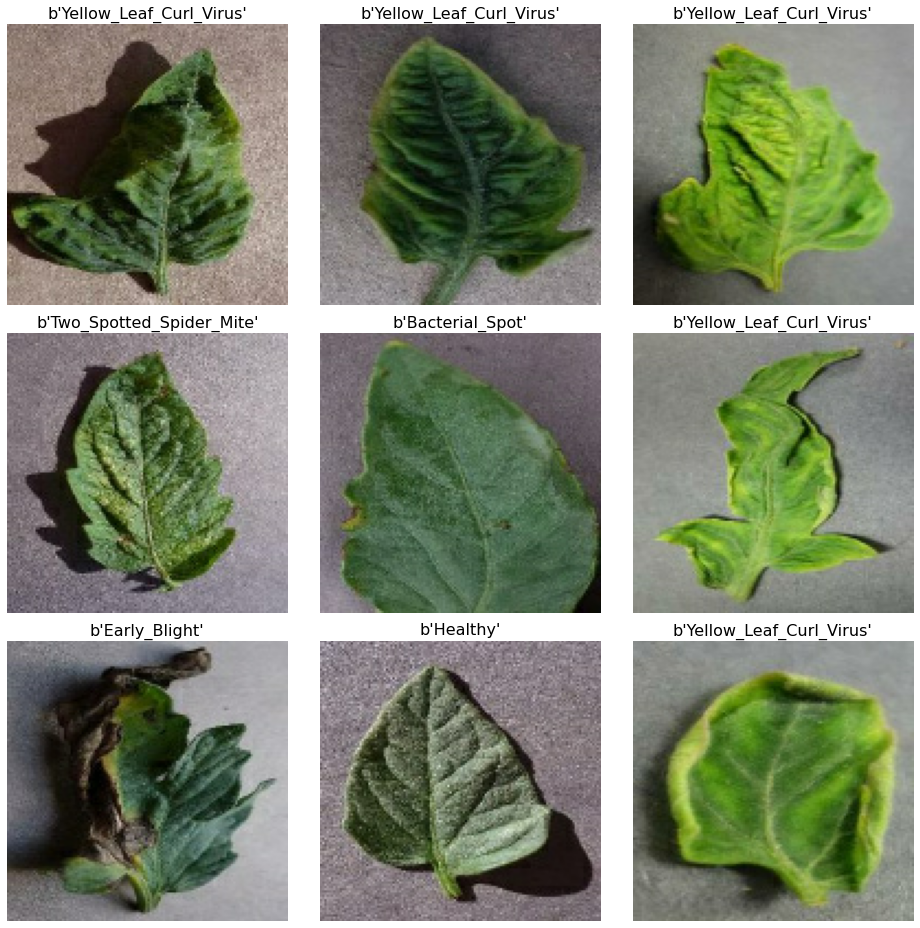

In [6]:
print(training_filenames)
display_9_images_from_dataset(load_dataset(training_filenames))

# Display 9 images from validation files

['/content/drive/My Drive/Plant_Disease_Clinic/tomato_tfrecords/tomato00-1240.tfrec', '/content/drive/My Drive/Plant_Disease_Clinic/tomato_tfrecords/tomato01-1240.tfrec', '/content/drive/My Drive/Plant_Disease_Clinic/tomato_tfrecords/tomato02-1240.tfrec']


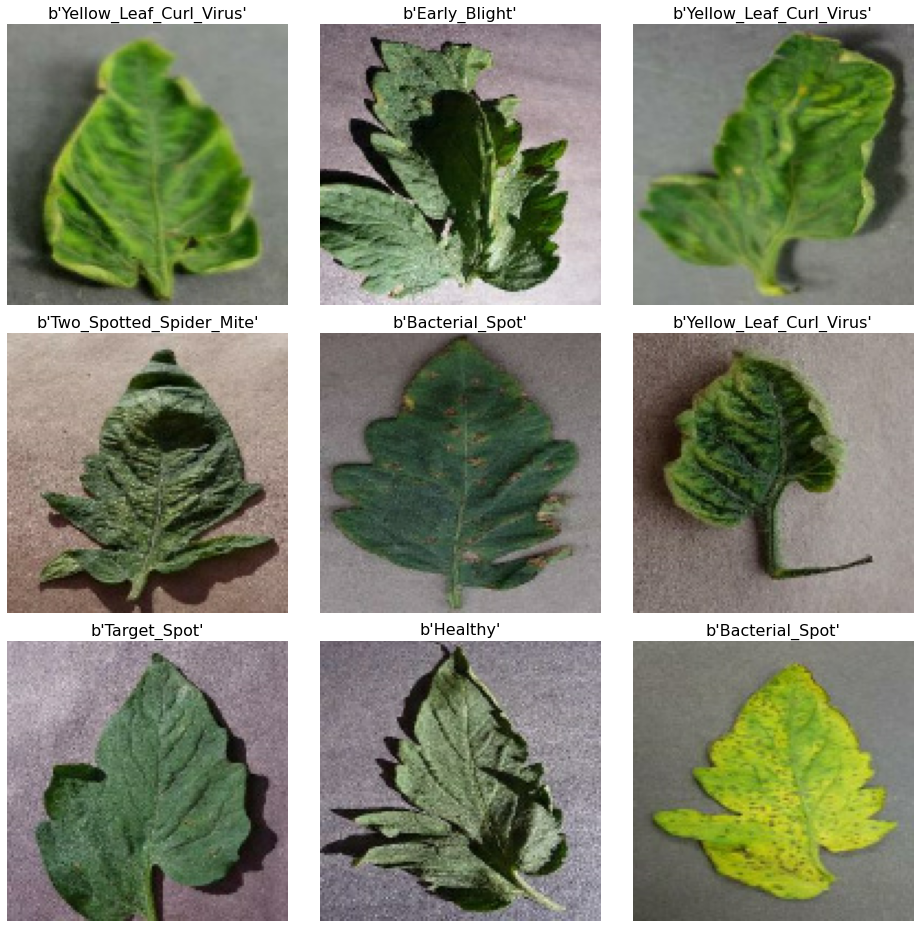

In [7]:
print(validation_filenames)
display_9_images_from_dataset(load_dataset(validation_filenames))

# Prepare training and validation datasets and Load into RAM

In [8]:
def get_batched_dataset(filenames, train=False):
  dataset = load_dataset(filenames)
  dataset = dataset.cache() # This dataset fits in RAM
  if train:
    # Best practices for Keras:
    # Training dataset: repeat then batch
    # Evaluation dataset: do not repeat
    dataset = dataset.repeat()
  dataset = dataset.batch(BATCH_SIZE)
  dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
  # should shuffle too but this dataset was well shuffled on disk already
  return dataset
  # source: Dataset performance guide: https://www.tensorflow.org/guide/performance/datasets

# instantiate the datasets
training_dataset = get_batched_dataset(training_filenames, train=True)
validation_dataset = get_batched_dataset(validation_filenames, train=False)

print(training_dataset)
print(validation_dataset)


<PrefetchDataset shapes: ((None, 128, 128, 3), (None,)), types: (tf.float32, tf.int64)>
<PrefetchDataset shapes: ((None, 128, 128, 3), (None,)), types: (tf.float32, tf.int64)>


# Model Creation(MobileNetV2)

In [9]:
pretrained_model = tf.keras.applications.MobileNetV2(input_shape=[*IMAGE_SIZE, 3], include_top=False)
pretrained_model.trainable = False

model_MobileNetV2 = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(NO_OF_CLASSES, activation='softmax')
])

model_MobileNetV2.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_MobileNetV2.summary()
model_MobileNetV2.input_shape

9412608/9406464 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Model) (None, 4, 4, 1280)        2257984   
_________________________________________________________________
flatten (Flatten)            (None, 20480)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               5243136   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 7,503,690
Trainable params: 5,245,706
Non-trainable params: 2,257,984
_________________________________________________________________


(None, 128, 128, 3)

# All Popular ResNet Models
# Model Creation (ResNet50V2)

In [10]:
pretrained_model = tf.keras.applications.ResNet50V2(input_shape=[*IMAGE_SIZE, 3], include_top=False)
pretrained_model.trainable = False

model_ResNet50V2 = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(NO_OF_CLASSES, activation='softmax')
])

model_ResNet50V2.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_ResNet50V2.summary()
model_ResNet50V2.input_shape

94674944/94668760 [==============================] - 7s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 4, 4, 2048)        23564800  
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               8388864   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                2570      
Total params: 31,956,234
Trainable params: 8,391,434
Non-trainable params: 23,564,800
_________________________________________________________________


(None, 128, 128, 3)

# Model Creation (ResNet101V2)

In [11]:
pretrained_model = tf.keras.applications.ResNet101V2(input_shape=[*IMAGE_SIZE, 3], include_top=False)
pretrained_model.trainable = False

model_ResNet101V2 = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(NO_OF_CLASSES, activation='softmax')
])

model_ResNet101V2.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_ResNet101V2.summary()
model_ResNet101V2.input_shape

171319296/171317808 [==============================] - 8s 0us/step
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101v2 (Model)          (None, 4, 4, 2048)        42626560  
_________________________________________________________________
flatten_2 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               8388864   
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                2570      
Total params: 51,017,994
Trainable params: 8,391,434
Non-trainable params: 42,626,560
_________________________________________________________________


(None, 128, 128, 3)

# Model Creation (ResNet152V2)

In [12]:
pretrained_model = tf.keras.applications.ResNet152V2(input_shape=[*IMAGE_SIZE, 3], include_top=False)
pretrained_model.trainable = False

model_ResNet152V2 = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(NO_OF_CLASSES, activation='softmax')
])

model_ResNet152V2.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_ResNet152V2.summary()
model_ResNet152V2.input_shape

234553344/234545216 [==============================] - 12s 0us/step
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152v2 (Model)          (None, 4, 4, 2048)        58331648  
_________________________________________________________________
flatten_3 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               8388864   
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                2570      
Total params: 66,723,082
Trainable params: 8,391,434
Non-trainable params: 58,331,648
_________________________________________________________________


(None, 128, 128, 3)

# Model Creation Xception

In [13]:
pretrained_model = tf.keras.applications.Xception(input_shape=[*IMAGE_SIZE, 3], include_top=False)
pretrained_model.trainable = False

model_Xception = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(NO_OF_CLASSES, activation='softmax')
])

model_Xception.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_Xception.summary()
model_Xception.input_shape

83689472/83683744 [==============================] - 2s 0us/step
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 4, 4, 2048)        20861480  
_________________________________________________________________
flatten_4 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               8388864   
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 10)                2570      
Total params: 29,252,914
Trainable params: 8,391,434
Non-trainable params: 20,861,480
_________________________________________________________________


(None, 128, 128, 3)

# All VGG Models
# Model Creation VGG16

In [14]:
pretrained_model = tf.keras.applications.VGG16(input_shape=[*IMAGE_SIZE, 3], include_top=False)
pretrained_model.trainable = False

model_VGG16 = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(NO_OF_CLASSES, activation='softmax')
])

model_VGG16.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_VGG16.summary()
model_VGG16.input_shape

58892288/58889256 [==============================] - 1s 0us/step
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_5 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 10)                2570      
Total params: 16,814,666
Trainable params: 2,099,978
Non-trainable params: 14,714,688
_________________________________________________________________


(None, 128, 128, 3)

# Model Creation VGG19

In [15]:
pretrained_model = tf.keras.applications.VGG19(input_shape=[*IMAGE_SIZE, 3], include_top=False)
pretrained_model.trainable = False

model_VGG19 = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(NO_OF_CLASSES, activation='softmax')
])

model_VGG19.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_VGG19.summary()
model_VGG19.input_shape

80142336/80134624 [==============================] - 6s 0us/step
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_6 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 10)                2570      
Total params: 22,124,362
Trainable params: 2,099,978
Non-trainable params: 20,024,384
_________________________________________________________________


(None, 128, 128, 3)

# Model Creation InceptionResNetV2

In [16]:
pretrained_model = tf.keras.applications.InceptionResNetV2(input_shape=[*IMAGE_SIZE, 3], include_top=False)
pretrained_model.trainable = False

model_InceptionResNetV2 = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(NO_OF_CLASSES, activation='softmax')
])

model_InceptionResNetV2.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_InceptionResNetV2.summary()
model_InceptionResNetV2.input_shape

219062272/219055592 [==============================] - 5s 0us/step
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 2, 2, 1536)        54336736  
_________________________________________________________________
flatten_7 (Flatten)          (None, 6144)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 256)               1573120   
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 10)                2570      
Total params: 55,912,426
Trainable params: 1,575,690
Non-trainable params: 54,336,736
_________________________________________________________________


(None, 128, 128, 3)

# Model Creation InceptionV3

In [17]:
pretrained_model = tf.keras.applications.InceptionV3(input_shape=[*IMAGE_SIZE, 3], include_top=False)
pretrained_model.trainable = False

model_InceptionV3 = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(NO_OF_CLASSES, activation='softmax')
])

model_InceptionV3.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_InceptionV3.summary()
model_InceptionV3.input_shape

87916544/87910968 [==============================] - 1s 0us/step
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 2, 2, 2048)        21802784  
_________________________________________________________________
flatten_8 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 10)                2570      
Total params: 23,902,762
Trainable params: 2,099,978
Non-trainable params: 21,802,784
_________________________________________________________________


(None, 128, 128, 3)

In [18]:
# Create List to store Training Time, Training Accuracy, Training Loss, Validation Accuracy, Validation Loss
training_details=[]

#Train the model(MobileNetV2)

In [19]:
start_time = time.time()
history = model_MobileNetV2.fit(training_dataset.repeat(), steps_per_epoch=steps_per_epoch, epochs=EPOCHS, 
                    validation_data=validation_dataset.repeat(), validation_steps=validation_steps, shuffle=True)
final_accuracy = history.history["val_accuracy"][-5:]
model_MobileNetV2_accuracy=round(np.mean(final_accuracy),2)
model_MobileNetV2_training_time= round((time.time() - start_time),2)
print("FINAL ACCURACY MEAN(MobileNetV2): ", model_MobileNetV2_accuracy)
print("TRAINING TIME: ", model_MobileNetV2_training_time , " sec")

Epoch 1/12
251/251 [==============================] - 16s 63ms/step - loss: 1.1378 - accuracy: 0.6680 - val_loss: 0.4641 - val_accuracy: 0.8594
Epoch 2/12
251/251 [==============================] - 13s 54ms/step - loss: 0.6165 - accuracy: 0.7863 - val_loss: 0.3691 - val_accuracy: 0.8774
Epoch 3/12
251/251 [==============================] - 13s 53ms/step - loss: 0.5075 - accuracy: 0.8230 - val_loss: 0.3515 - val_accuracy: 0.8860
Epoch 4/12
251/251 [==============================] - 13s 53ms/step - loss: 0.4142 - accuracy: 0.8507 - val_loss: 0.2786 - val_accuracy: 0.9076
Epoch 5/12
251/251 [==============================] - 13s 53ms/step - loss: 0.3781 - accuracy: 0.8651 - val_loss: 0.2971 - val_accuracy: 0.9062
Epoch 6/12
251/251 [==============================] - 13s 53ms/step - loss: 0.3513 - accuracy: 0.8738 - val_loss: 0.2917 - val_accuracy: 0.9108
Epoch 7/12
251/251 [==============================] - 13s 53ms/step - loss: 0.2999 - accuracy: 0.8896 - val_loss: 0.2618 - val_accuracy:

# Training and Validation Accuracy Graph(MobileNetv2)
# Training and Validation Loss Graph(MobileNetv2)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


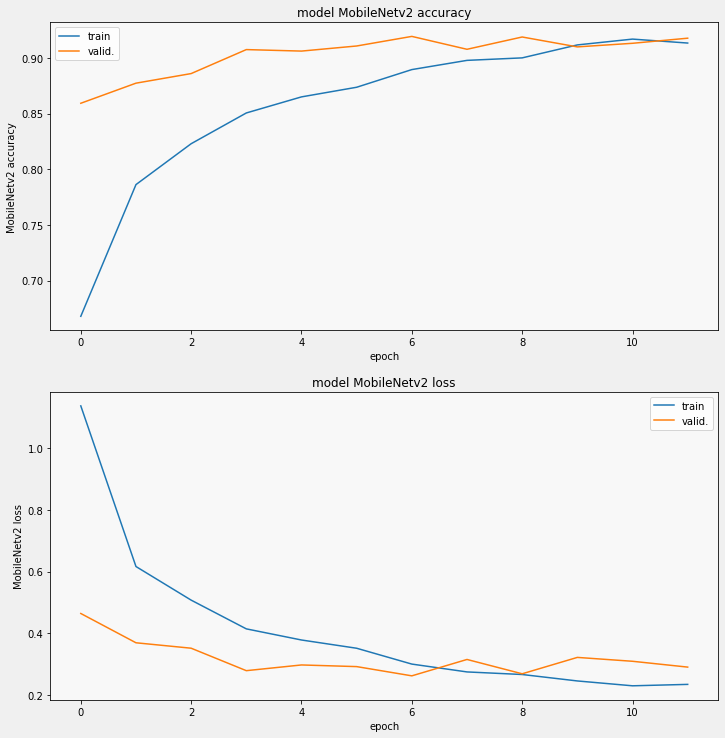

In [20]:
print(history.history.keys())
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'MobileNetv2 accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'MobileNetv2 loss', 212)

# Train the model(ResNet50V2)

In [21]:
start_time = time.time()
history = model_ResNet50V2.fit(training_dataset.repeat(), steps_per_epoch=steps_per_epoch, epochs=EPOCHS, 
                    validation_data=validation_dataset.repeat(), validation_steps=validation_steps, shuffle=True)
final_accuracy = history.history["val_accuracy"][-5:]
model_ResNet50V2_accuracy=round(np.mean(final_accuracy),2)
model_ResNet50V2_training_time= round((time.time() - start_time),2)
print("FINAL ACCURACY MEAN(ResNet50V2): ", model_ResNet50V2_accuracy)
print("TRAINING TIME: ", model_ResNet50V2_training_time , " sec")


Epoch 1/12
251/251 [==============================] - 26s 102ms/step - loss: 1.5641 - accuracy: 0.5812 - val_loss: 0.7020 - val_accuracy: 0.7745
Epoch 2/12
251/251 [==============================] - 25s 100ms/step - loss: 0.8784 - accuracy: 0.7005 - val_loss: 0.6188 - val_accuracy: 0.8179
Epoch 3/12
251/251 [==============================] - 25s 99ms/step - loss: 0.7531 - accuracy: 0.7392 - val_loss: 0.5496 - val_accuracy: 0.8314
Epoch 4/12
251/251 [==============================] - 25s 99ms/step - loss: 0.6552 - accuracy: 0.7698 - val_loss: 0.4721 - val_accuracy: 0.8556
Epoch 5/12
251/251 [==============================] - 25s 99ms/step - loss: 0.5783 - accuracy: 0.7930 - val_loss: 0.4648 - val_accuracy: 0.8629
Epoch 6/12
251/251 [==============================] - 25s 99ms/step - loss: 0.5204 - accuracy: 0.8143 - val_loss: 0.3816 - val_accuracy: 0.8774
Epoch 7/12
251/251 [==============================] - 25s 99ms/step - loss: 0.4619 - accuracy: 0.8325 - val_loss: 0.4276 - val_accurac

# Training and Validation Accuracy Graph(ResNet50V2)
# Training and Validation Loss Graph(ResNet50V2)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


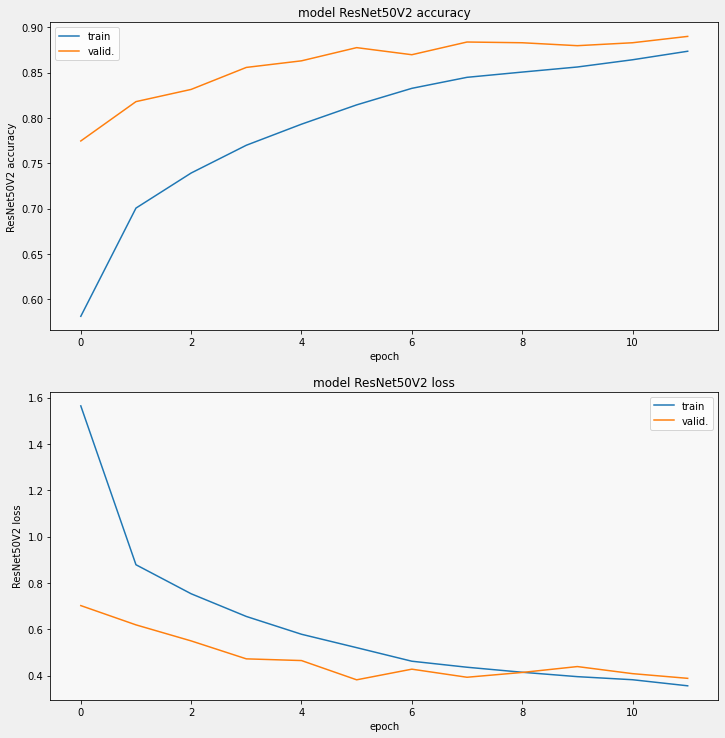

In [22]:
print(history.history.keys())
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'ResNet50V2 accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'ResNet50V2 loss', 212)

# Train the model(ResNet101V2)

In [23]:
start_time = time.time()
history = model_ResNet101V2.fit(training_dataset.repeat(), steps_per_epoch=steps_per_epoch, epochs=EPOCHS, 
                    validation_data=validation_dataset.repeat(), validation_steps=validation_steps, shuffle=True)
final_accuracy = history.history["val_accuracy"][-5:]
model_ResNet101V2_accuracy=round(np.mean(final_accuracy),2)
model_ResNet101V2_training_time= round((time.time() - start_time),2)
print("FINAL ACCURACY MEAN(ResNet101V2): ", model_ResNet101V2_accuracy)
print("TRAINING TIME: ", model_ResNet101V2_training_time , " sec")

Epoch 1/12
251/251 [==============================] - 42s 169ms/step - loss: 1.4597 - accuracy: 0.6111 - val_loss: 0.6178 - val_accuracy: 0.8087
Epoch 2/12
251/251 [==============================] - 41s 164ms/step - loss: 0.7845 - accuracy: 0.7338 - val_loss: 0.5427 - val_accuracy: 0.8192
Epoch 3/12
251/251 [==============================] - 41s 164ms/step - loss: 0.6479 - accuracy: 0.7785 - val_loss: 0.4457 - val_accuracy: 0.8559
Epoch 4/12
251/251 [==============================] - 41s 163ms/step - loss: 0.5355 - accuracy: 0.8124 - val_loss: 0.4040 - val_accuracy: 0.8699
Epoch 5/12
251/251 [==============================] - 41s 163ms/step - loss: 0.4740 - accuracy: 0.8350 - val_loss: 0.3618 - val_accuracy: 0.8823
Epoch 6/12
251/251 [==============================] - 41s 163ms/step - loss: 0.4244 - accuracy: 0.8487 - val_loss: 0.3791 - val_accuracy: 0.8820
Epoch 7/12
251/251 [==============================] - 41s 163ms/step - loss: 0.3813 - accuracy: 0.8648 - val_loss: 0.3772 - val_ac

# Training and Validation Accuracy Graph(ResNet101V2)
# Training and Validation Loss Graph(ResNet101V2)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


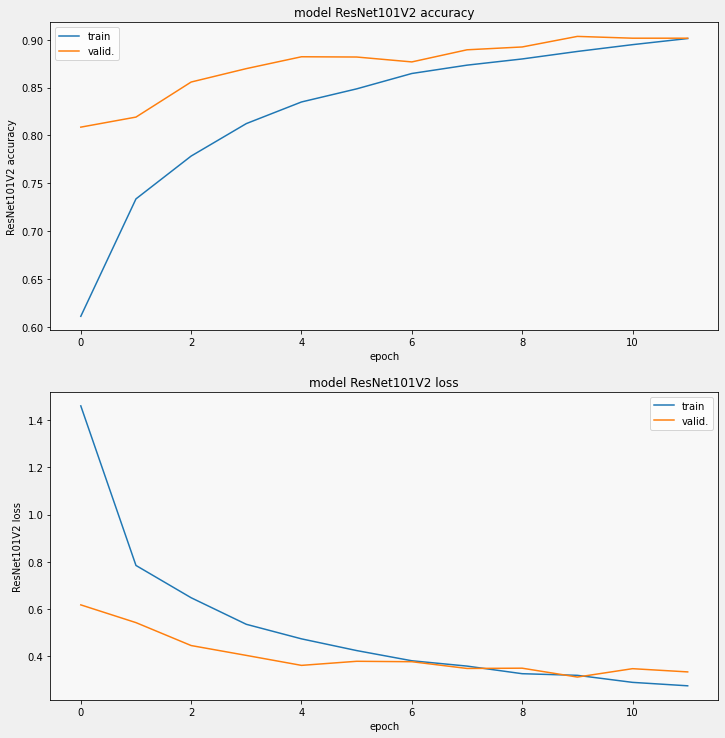

In [24]:
print(history.history.keys())
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'ResNet101V2 accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'ResNet101V2 loss', 212)

# Train the model(ResNet152V2)

In [25]:
start_time = time.time()
history = model_ResNet152V2.fit(training_dataset.repeat(), steps_per_epoch=steps_per_epoch, epochs=EPOCHS, 
                    validation_data=validation_dataset.repeat(), validation_steps=validation_steps, shuffle=True)
final_accuracy = history.history["val_accuracy"][-5:]

model_ResNet152V2_accuracy=round(np.mean(final_accuracy),2)
model_ResNet152V2_training_time= round((time.time() - start_time),2)
print("FINAL ACCURACY MEAN(ResNet152V2): ", model_ResNet152V2_accuracy)
print("TRAINING TIME: ", model_ResNet152V2_training_time , " sec")

Epoch 1/12
251/251 [==============================] - 61s 242ms/step - loss: 1.5127 - accuracy: 0.6117 - val_loss: 0.6979 - val_accuracy: 0.7834
Epoch 2/12
251/251 [==============================] - 58s 233ms/step - loss: 0.8568 - accuracy: 0.7157 - val_loss: 0.5936 - val_accuracy: 0.8149
Epoch 3/12
251/251 [==============================] - 58s 233ms/step - loss: 0.6818 - accuracy: 0.7697 - val_loss: 0.4924 - val_accuracy: 0.8440
Epoch 4/12
251/251 [==============================] - 59s 233ms/step - loss: 0.5978 - accuracy: 0.7938 - val_loss: 0.4153 - val_accuracy: 0.8661
Epoch 5/12
251/251 [==============================] - 59s 233ms/step - loss: 0.5262 - accuracy: 0.8165 - val_loss: 0.3751 - val_accuracy: 0.8745
Epoch 6/12
251/251 [==============================] - 58s 233ms/step - loss: 0.4655 - accuracy: 0.8405 - val_loss: 0.3648 - val_accuracy: 0.8887
Epoch 7/12
251/251 [==============================] - 58s 233ms/step - loss: 0.4093 - accuracy: 0.8545 - val_loss: 0.3613 - val_ac

# Training and Validation Accuracy Graph(ResNet152V2)
# Training and Validation Loss Graph(ResNet152V2)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


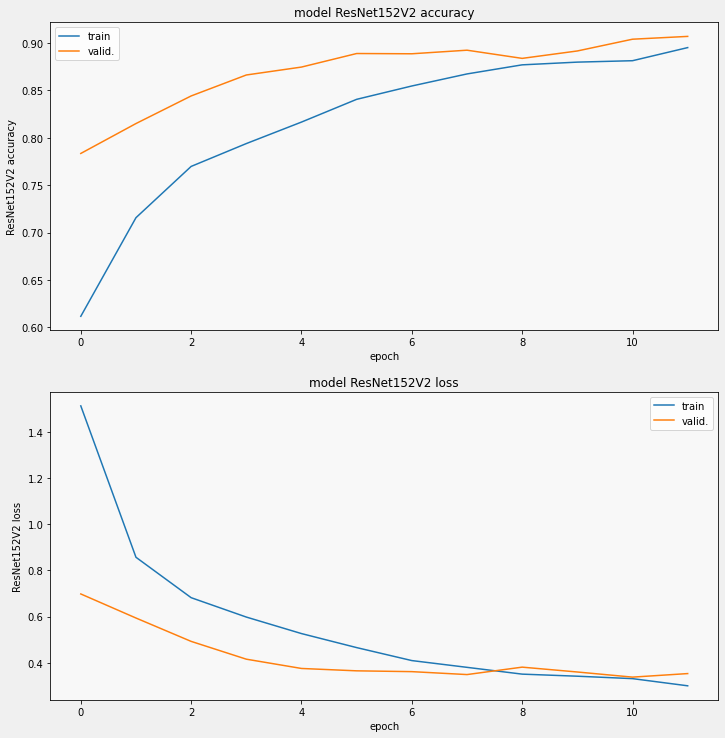

In [26]:
print(history.history.keys())
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'ResNet152V2 accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'ResNet152V2 loss', 212)

# Train the model(Xception)

In [27]:
start_time = time.time()
history = model_Xception.fit(training_dataset.repeat(), steps_per_epoch=steps_per_epoch, epochs=EPOCHS, 
                    validation_data=validation_dataset.repeat(), validation_steps=validation_steps, shuffle=True)
final_accuracy = history.history["val_accuracy"][-5:]

model_Xception_accuracy=round(np.mean(final_accuracy),2)
model_Xception_training_time= round((time.time() - start_time),2)
print("FINAL ACCURACY MEAN(Xception): ", model_Xception_accuracy)
print("TRAINING TIME: ", model_Xception_training_time , " sec")

Epoch 1/12
251/251 [==============================] - 32s 126ms/step - loss: 1.4428 - accuracy: 0.5519 - val_loss: 0.7536 - val_accuracy: 0.7777
Epoch 2/12
251/251 [==============================] - 31s 124ms/step - loss: 0.9444 - accuracy: 0.6740 - val_loss: 0.6308 - val_accuracy: 0.8017
Epoch 3/12
251/251 [==============================] - 31s 124ms/step - loss: 0.8333 - accuracy: 0.7083 - val_loss: 0.5885 - val_accuracy: 0.8152
Epoch 4/12
251/251 [==============================] - 31s 124ms/step - loss: 0.7528 - accuracy: 0.7319 - val_loss: 0.5371 - val_accuracy: 0.8203
Epoch 5/12
251/251 [==============================] - 31s 125ms/step - loss: 0.7088 - accuracy: 0.7539 - val_loss: 0.5369 - val_accuracy: 0.8209
Epoch 6/12
251/251 [==============================] - 31s 124ms/step - loss: 0.6669 - accuracy: 0.7681 - val_loss: 0.4761 - val_accuracy: 0.8456
Epoch 7/12
251/251 [==============================] - 31s 124ms/step - loss: 0.6328 - accuracy: 0.7747 - val_loss: 0.4876 - val_ac

# Training and Validation Accuracy Graph(model_Xception)
# Training and Validation Loss Graph(model_Xception)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


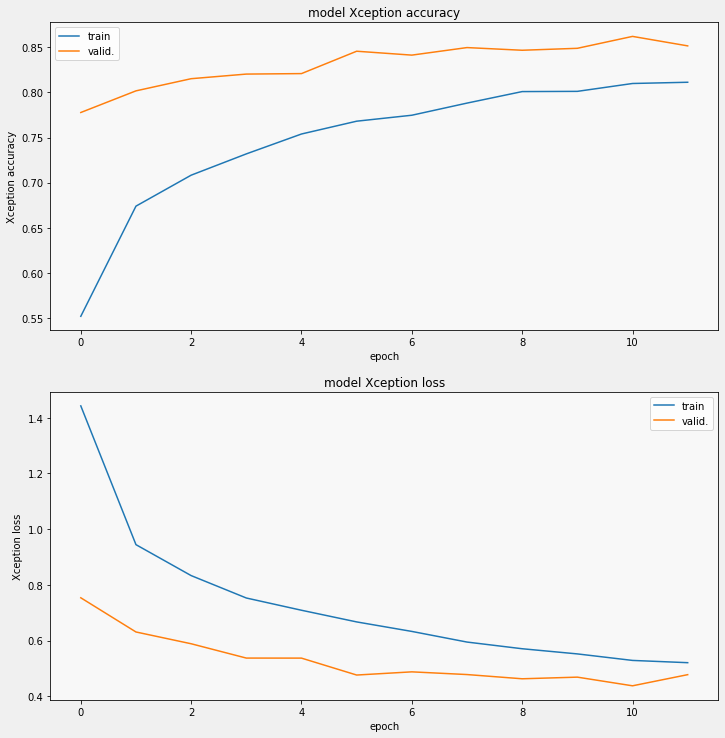

In [28]:
print(history.history.keys())
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'Xception accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'Xception loss', 212)

# Train the model(VGG16)

In [29]:
start_time = time.time()
history = model_VGG16.fit(training_dataset.repeat(), steps_per_epoch=steps_per_epoch, epochs=EPOCHS, 
                    validation_data=validation_dataset.repeat(), validation_steps=validation_steps, shuffle=True)
final_accuracy = history.history["val_accuracy"][-5:]


model_VGG16_accuracy=round(np.mean(final_accuracy),2)
model_VGG16_training_time= round((time.time() - start_time),2)
print("FINAL ACCURACY MEAN(VGG16): ", model_VGG16_accuracy)
print("TRAINING TIME: ", model_VGG16_training_time , " sec")

Epoch 1/12
251/251 [==============================] - 39s 154ms/step - loss: 1.0121 - accuracy: 0.6711 - val_loss: 0.5391 - val_accuracy: 0.8351
Epoch 2/12
251/251 [==============================] - 39s 154ms/step - loss: 0.6101 - accuracy: 0.7974 - val_loss: 0.4288 - val_accuracy: 0.8653
Epoch 3/12
251/251 [==============================] - 38s 153ms/step - loss: 0.5011 - accuracy: 0.8314 - val_loss: 0.3884 - val_accuracy: 0.8745
Epoch 4/12
251/251 [==============================] - 38s 153ms/step - loss: 0.4425 - accuracy: 0.8489 - val_loss: 0.3270 - val_accuracy: 0.8930
Epoch 5/12
251/251 [==============================] - 38s 153ms/step - loss: 0.4047 - accuracy: 0.8633 - val_loss: 0.3092 - val_accuracy: 0.8947
Epoch 6/12
251/251 [==============================] - 38s 152ms/step - loss: 0.3556 - accuracy: 0.8784 - val_loss: 0.3036 - val_accuracy: 0.9017
Epoch 7/12
251/251 [==============================] - 38s 153ms/step - loss: 0.3317 - accuracy: 0.8847 - val_loss: 0.2966 - val_ac

# Training and Validation Accuracy Graph(VGG16)
# Training and Validation Loss Graph(VGG16)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


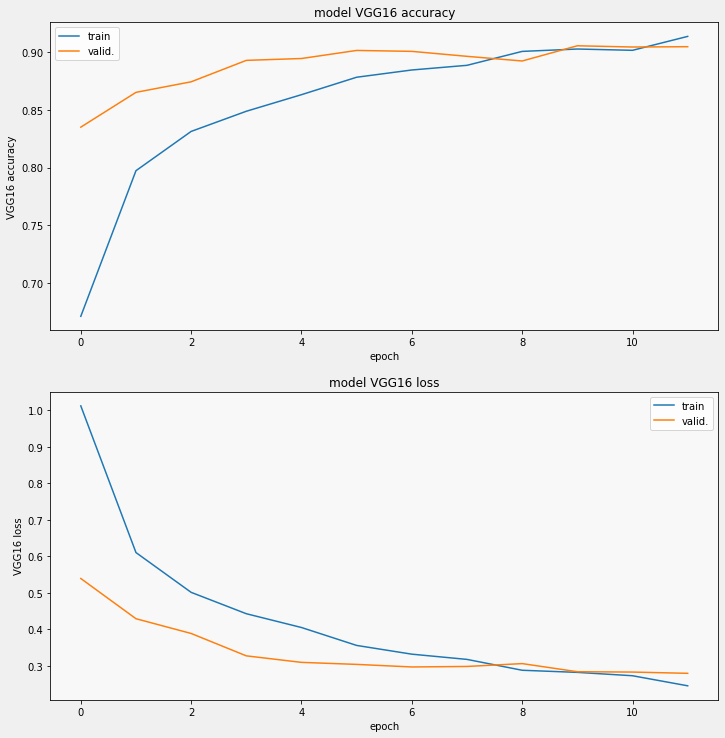

In [30]:
print(history.history.keys())
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'VGG16 accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'VGG16 loss', 212)

# Train the model(VGG19)

In [31]:
start_time = time.time()
history = model_VGG19.fit(training_dataset.repeat(), steps_per_epoch=steps_per_epoch, epochs=EPOCHS, 
                    validation_data=validation_dataset.repeat(), validation_steps=validation_steps, shuffle=True)
final_accuracy = history.history["val_accuracy"][-5:]

model_VGG19_accuracy=round(np.mean(final_accuracy),2)
model_VGG19_training_time= round((time.time() - start_time),2)
print("FINAL ACCURACY MEAN(VGG19): ", model_VGG19_accuracy)
print("TRAINING TIME: ", model_VGG19_training_time , " sec")

Epoch 1/12
251/251 [==============================] - 45s 180ms/step - loss: 1.1932 - accuracy: 0.6187 - val_loss: 0.6730 - val_accuracy: 0.7856
Epoch 2/12
251/251 [==============================] - 45s 181ms/step - loss: 0.7759 - accuracy: 0.7394 - val_loss: 0.5526 - val_accuracy: 0.8260
Epoch 3/12
251/251 [==============================] - 45s 179ms/step - loss: 0.6800 - accuracy: 0.7679 - val_loss: 0.4963 - val_accuracy: 0.8370
Epoch 4/12
251/251 [==============================] - 45s 179ms/step - loss: 0.6223 - accuracy: 0.7893 - val_loss: 0.4482 - val_accuracy: 0.8481
Epoch 5/12
251/251 [==============================] - 45s 180ms/step - loss: 0.5644 - accuracy: 0.8067 - val_loss: 0.4078 - val_accuracy: 0.8621
Epoch 6/12
251/251 [==============================] - 45s 180ms/step - loss: 0.5384 - accuracy: 0.8150 - val_loss: 0.4252 - val_accuracy: 0.8575
Epoch 7/12
251/251 [==============================] - 45s 180ms/step - loss: 0.5013 - accuracy: 0.8235 - val_loss: 0.4293 - val_ac

# Training and Validation Accuracy Graph(VGG19)
# Training and Validation Loss Graph(VGG19)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


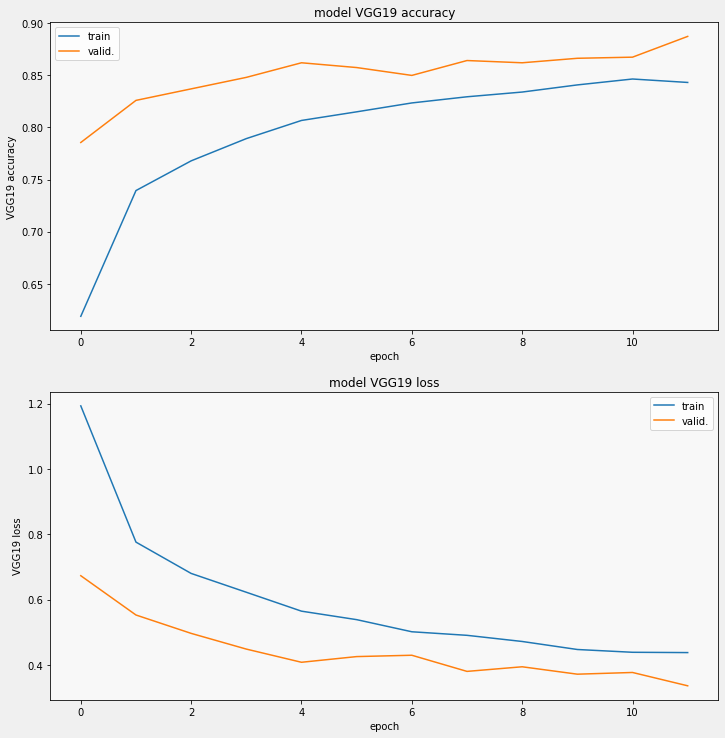

In [32]:
print(history.history.keys())
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'VGG19 accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'VGG19 loss', 212)

# Train the model(InceptionResNetV2)

In [33]:
start_time = time.time()
history = model_InceptionResNetV2.fit(training_dataset.repeat(), steps_per_epoch=steps_per_epoch, epochs=EPOCHS, 
                    validation_data=validation_dataset.repeat(), validation_steps=validation_steps, shuffle=True)
final_accuracy = history.history["val_accuracy"][-5:]

model_InceptionResNetV2_accuracy=round(np.mean(final_accuracy),2)
model_InceptionResNetV2_training_time= round((time.time() - start_time),2)
print("FINAL ACCURACY MEAN(InceptionResNetV2): ", model_InceptionResNetV2_accuracy)
print("TRAINING TIME: ", model_InceptionResNetV2_training_time , " sec")

Epoch 1/12
251/251 [==============================] - 44s 175ms/step - loss: 1.5383 - accuracy: 0.5311 - val_loss: 0.8726 - val_accuracy: 0.7077
Epoch 2/12
251/251 [==============================] - 41s 163ms/step - loss: 1.0013 - accuracy: 0.6519 - val_loss: 0.7467 - val_accuracy: 0.7648
Epoch 3/12
251/251 [==============================] - 41s 162ms/step - loss: 0.9051 - accuracy: 0.6861 - val_loss: 0.6586 - val_accuracy: 0.7928
Epoch 4/12
251/251 [==============================] - 41s 162ms/step - loss: 0.8306 - accuracy: 0.7035 - val_loss: 0.5885 - val_accuracy: 0.8155
Epoch 5/12
251/251 [==============================] - 41s 162ms/step - loss: 0.7504 - accuracy: 0.7377 - val_loss: 0.5535 - val_accuracy: 0.8209
Epoch 6/12
251/251 [==============================] - 41s 162ms/step - loss: 0.6997 - accuracy: 0.7525 - val_loss: 0.5298 - val_accuracy: 0.8289
Epoch 7/12
251/251 [==============================] - 41s 162ms/step - loss: 0.6780 - accuracy: 0.7610 - val_loss: 0.5396 - val_ac

# Training and Validation Accuracy Graph(InceptionResNetV2)
# Training and Validation Loss Graph(InceptionResNetV2)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


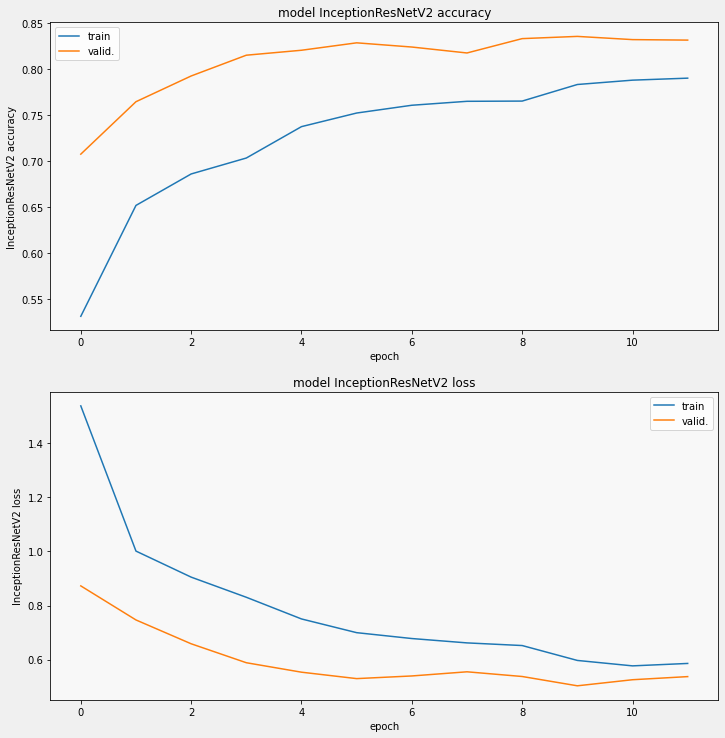

In [34]:
print(history.history.keys())
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'InceptionResNetV2 accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'InceptionResNetV2 loss', 212)

# Train the model(InceptionV3)

In [35]:
start_time = time.time()
history = model_InceptionV3.fit(training_dataset.repeat(), steps_per_epoch=steps_per_epoch, epochs=EPOCHS, 
                    validation_data=validation_dataset.repeat(), validation_steps=validation_steps, shuffle=True)
final_accuracy = history.history["val_accuracy"][-5:]

model_InceptionV3_accuracy=round(np.mean(final_accuracy),2)
model_InceptionV3_training_time= round((time.time() - start_time),2)
print("FINAL ACCURACY MEAN(InceptionV3): ", model_InceptionV3_accuracy)
print("TRAINING TIME: ", model_InceptionV3_training_time , " sec")

Epoch 1/12
251/251 [==============================] - 20s 80ms/step - loss: 1.5676 - accuracy: 0.5316 - val_loss: 0.9531 - val_accuracy: 0.6894
Epoch 2/12
251/251 [==============================] - 19s 75ms/step - loss: 1.0996 - accuracy: 0.6158 - val_loss: 0.7618 - val_accuracy: 0.7497
Epoch 3/12
251/251 [==============================] - 19s 75ms/step - loss: 0.9738 - accuracy: 0.6539 - val_loss: 0.7121 - val_accuracy: 0.7716
Epoch 4/12
251/251 [==============================] - 19s 76ms/step - loss: 0.9162 - accuracy: 0.6780 - val_loss: 0.7038 - val_accuracy: 0.7740
Epoch 5/12
251/251 [==============================] - 19s 76ms/step - loss: 0.8535 - accuracy: 0.6967 - val_loss: 0.6616 - val_accuracy: 0.7845
Epoch 6/12
251/251 [==============================] - 19s 75ms/step - loss: 0.8242 - accuracy: 0.7054 - val_loss: 0.6648 - val_accuracy: 0.7856
Epoch 7/12
251/251 [==============================] - 19s 75ms/step - loss: 0.7745 - accuracy: 0.7201 - val_loss: 0.6696 - val_accuracy:

# Training and Validation Accuracy Graph(InceptionV3)
# Training and Validation Loss Graph(InceptionV3)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


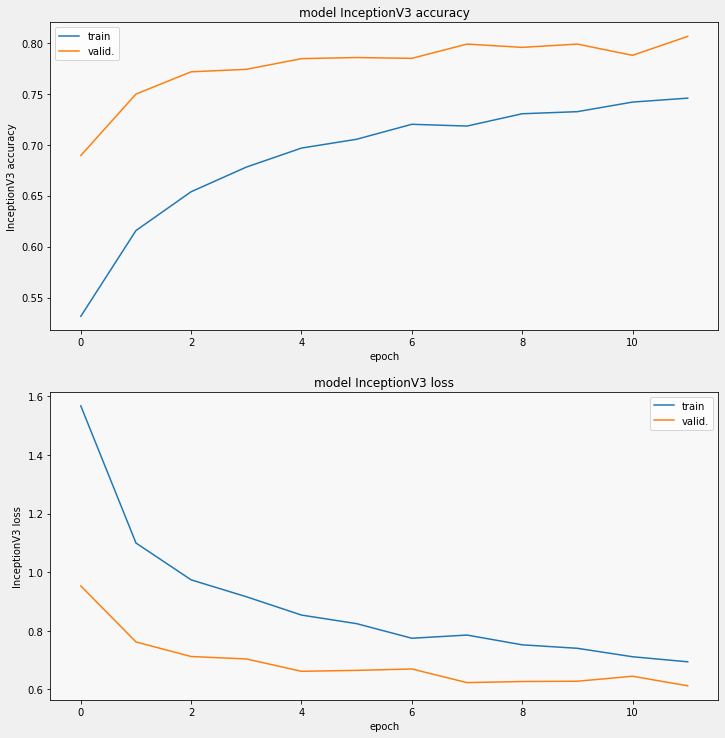

In [36]:
print(history.history.keys())
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'InceptionV3 accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'InceptionV3 loss', 212)

In [37]:
training_details = [ 
        { 
        "Model": [{"Accuracy": model_MobileNetV2_accuracy, "Training Time": model_MobileNetV2_training_time} 
                   ], 
        "Name": "MobileNetV2"
        }, 
        { 
        "Model": [{"Accuracy": model_ResNet50V2_accuracy, "Training Time": model_ResNet50V2_training_time}                    
                  ], 
        "Name": "ResNet50V2"
        },
        { 
        "Model": [{"Accuracy": model_ResNet101V2_accuracy, "Training Time": model_ResNet101V2_training_time}                    
                  ], 
        "Name": "ResNet101V2"
        },
        { 
        "Model": [{"Accuracy": model_ResNet152V2_accuracy, "Training Time": model_ResNet152V2_training_time}                    
                  ], 
        "Name": "ResNet152V2"
        },
        { 
        "Model": [{"Accuracy": model_Xception_accuracy, "Training Time": model_Xception_training_time}                    
                  ], 
        "Name": "Xception"
        },
        { 
        "Model": [{"Accuracy": model_VGG16_accuracy, "Training Time": model_VGG16_training_time}                    
                  ], 
        "Name": "VGG16"
        },
        { 
        "Model": [{"Accuracy": model_VGG19_accuracy, "Training Time": model_VGG19_training_time}                    
                  ], 
        "Name": "VGG19"
        },
        { 
        "Model": [{"Accuracy": model_InceptionResNetV2_accuracy, "Training Time": model_InceptionResNetV2_training_time}                    
                  ], 
        "Name": "InceptionResNetV2"
        },
        { 
        "Model": [{"Accuracy": model_InceptionV3_accuracy, "Training Time": model_InceptionV3_training_time}                    
                  ], 
        "Name": "InceptionV3"
        }
       ] 

In [38]:
training_details

[{'Model': [{'Accuracy': 0.91, 'Training Time': 171.6}],
  'Name': 'MobileNetV2'},
 {'Model': [{'Accuracy': 0.88, 'Training Time': 302.82}],
  'Name': 'ResNet50V2'},
 {'Model': [{'Accuracy': 0.9, 'Training Time': 499.15}],
  'Name': 'ResNet101V2'},
 {'Model': [{'Accuracy': 0.9, 'Training Time': 713.08}],
  'Name': 'ResNet152V2'},
 {'Model': [{'Accuracy': 0.85, 'Training Time': 378.25}], 'Name': 'Xception'},
 {'Model': [{'Accuracy': 0.9, 'Training Time': 465.21}], 'Name': 'VGG16'},
 {'Model': [{'Accuracy': 0.87, 'Training Time': 544.63}], 'Name': 'VGG19'},
 {'Model': [{'Accuracy': 0.83, 'Training Time': 504.09}],
  'Name': 'InceptionResNetV2'},
 {'Model': [{'Accuracy': 0.8, 'Training Time': 232.87}],
  'Name': 'InceptionV3'}]

In [39]:
model_name=['MobileNetV2', 'ResNet50V2','ResNet101V2','ResNet152V2','Xception','VGG16','VGG19','InceptionResNetV2','InceptionV3']
model_accuracy=[model_MobileNetV2_accuracy, model_ResNet50V2_accuracy ,model_ResNet101V2_accuracy,model_ResNet152V2_accuracy,model_Xception_accuracy,model_VGG16_accuracy,model_VGG19_accuracy,model_InceptionResNetV2_accuracy,model_InceptionV3_accuracy]
model_training_time=[model_MobileNetV2_training_time,model_ResNet50V2_training_time,model_ResNet101V2_training_time,model_ResNet152V2_training_time,model_Xception_training_time,model_VGG16_training_time,model_VGG19_training_time,model_InceptionResNetV2_training_time,model_InceptionV3_training_time]

In [40]:
import pandas as pd 

df = pd.DataFrame(list(zip(model_name, model_accuracy,model_training_time )), 
               columns =['Model Name', 'Accuracy', 'Training Time']) 
df 

Model Name  Accuracy  Training Time
0        MobileNetV2      0.91         171.60
1         ResNet50V2      0.88         302.82
2        ResNet101V2      0.90         499.15
3        ResNet152V2      0.90         713.08
4           Xception      0.85         378.25
5              VGG16      0.90         465.21
6              VGG19      0.87         544.63
7  InceptionResNetV2      0.83         504.09
8        InceptionV3      0.80         232.87

In [41]:
df['Training Time'] = np.log(df['Training Time'])

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


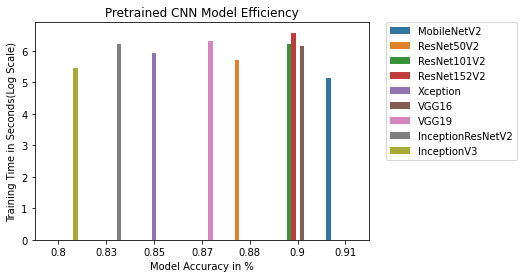

In [43]:
ax=sns.barplot(y="Training Time", x="Accuracy", hue="Model Name", data=df)
ax.set_title('Pretrained CNN Model Efficiency')
ax.set_ylabel('Training Time in Seconds(Log Scale)')
ax.set_xlabel('Model Accuracy in %')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Predictions

[b'Yellow_Leaf_Curl_Virus', b'Target_Spot', b'Bacterial_Spot', b'Target_Spot', b'Yellow_Leaf_Curl_Virus', b'Target_Spot', b'Healthy', b'Septoria_Leaf_Spot', b'Yellow_Leaf_Curl_Virus']


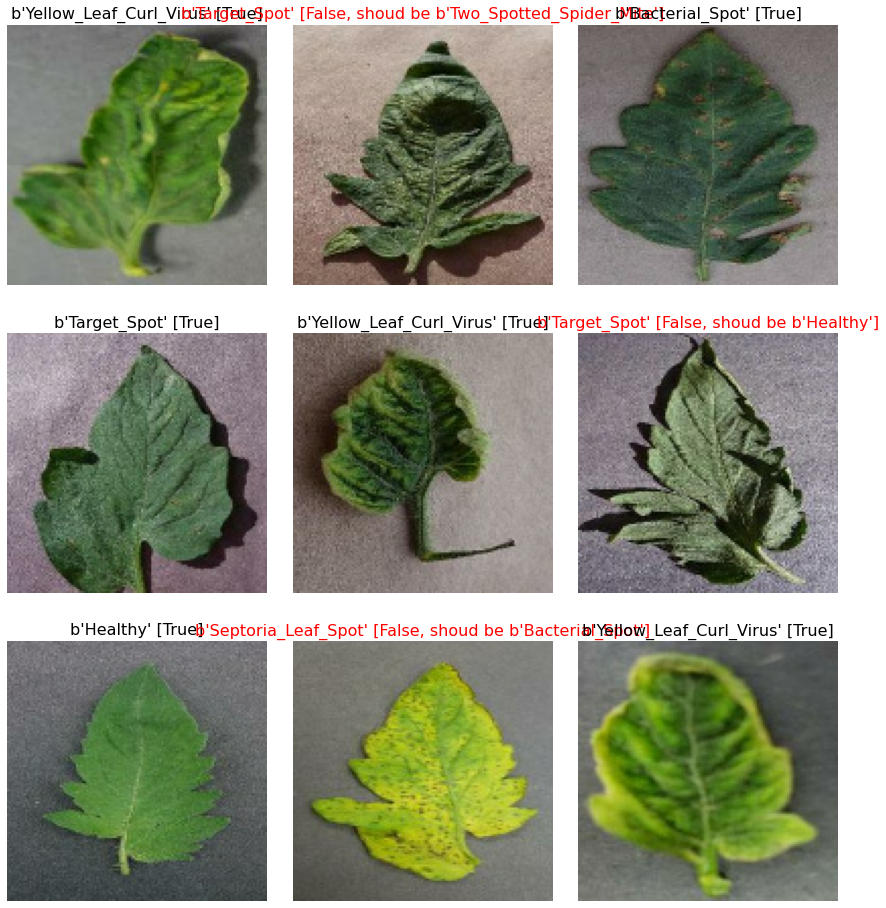

In [44]:
# random input: execute multiple times to change results
#print(load_dataset(validation_filenames.skip(np.random.randint(300)))
potatos, labels = dataset_to_numpy_util(load_dataset(validation_filenames).skip(np.random.randint(16)), 9)

predictions = model_MobileNetV2.predict(potatos, steps=1 )
print(np.array(CLASSES)[np.argmax(predictions, axis=-1)].tolist())
#print(validation_filenames)

display_9_images_with_predictions(potatos, predictions, labels)

# Save The Model



In [45]:
# Save JSON config to disk
json_config = model_MobileNetV2.to_json()
with open('/content/drive/My Drive/Plant_Disease_Clinic/Model/Tomato/tomato_model_config_MobileNetV2.json', 'w') as json_file:
    json_file.write(json_config)
# Save weights to disk
model_MobileNetV2.save_weights('/content/drive/My Drive/Plant_Disease_Clinic/Model/Tomato/tomato_weights_MobileNetV2.h5')

# Reload the model from the 2 files we saved
with open('/content/drive/My Drive/Plant_Disease_Clinic/Model/Tomato/tomato_model_config_MobileNetV2.json') as json_file:
     json_config = json_file.read()
my_saved_model = tf.keras.models.model_from_json(json_config)
my_saved_model.load_weights('/content/drive/My Drive/Plant_Disease_Clinic/Model/Tomato/tomato_weights_MobileNetV2.h5')


# Load The Saved Model

In [46]:
print(my_saved_model.summary())
print(my_saved_model.input_shape)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Model) (None, 4, 4, 1280)        2257984   
_________________________________________________________________
flatten (Flatten)            (None, 20480)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               5243136   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 7,503,690
Trainable params: 5,245,706
Non-trainable params: 2,257,984
_________________________________________________________________
None
(None, 128, 128, 3)


# Predict From Saved Model

[b'Leaf_Mold', b'Target_Spot', b'Yellow_Leaf_Curl_Virus', b'Target_Spot', b'Yellow_Leaf_Curl_Virus', b'Septoria_Leaf_Spot', b'Early_Blight', b'Healthy', b'Healthy']


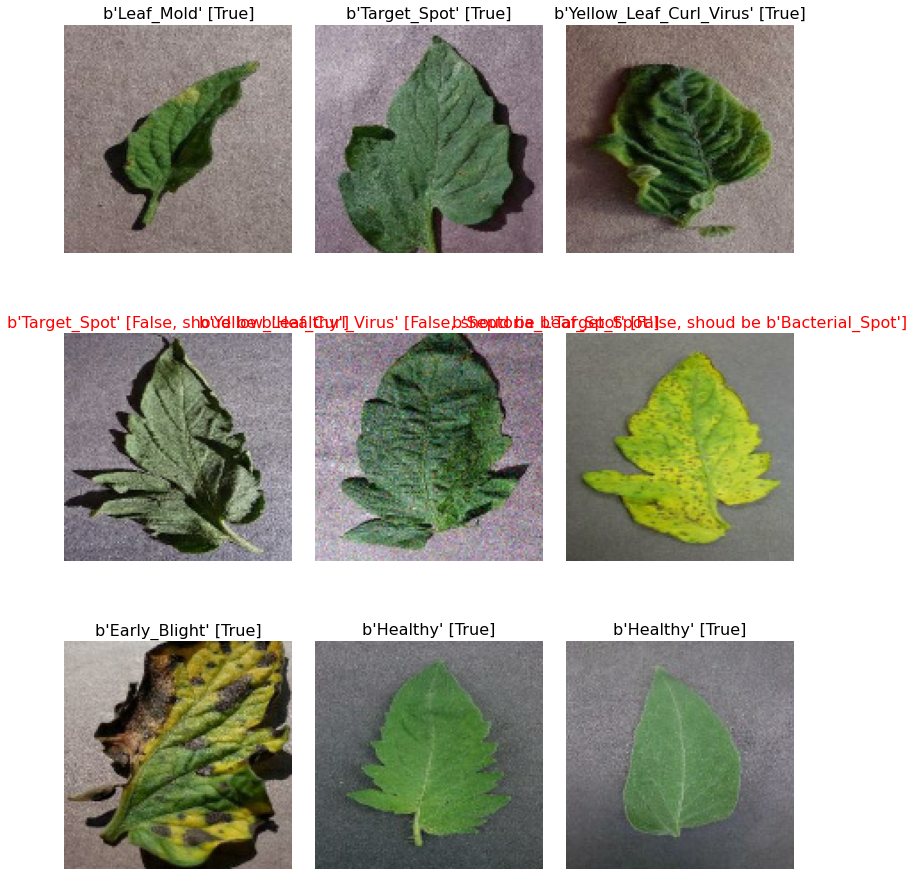

In [47]:
# random input: execute multiple times to change results
potatos, labels = dataset_to_numpy_util(load_dataset(validation_filenames).skip(np.random.randint(30)), 9)
predictions = my_saved_model.predict(potatos, steps=1 )
print(np.array(CLASSES)[np.argmax(predictions, axis=-1)].tolist())
display_9_images_with_predictions(potatos, predictions, labels)